In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

### Define fitness function

In [10]:
# fitness_func = lambda x: -jnp.sum((x - 5.0) * (x - 5.0), axis=-1)

In [4]:
num_iterations = 1000 # 70000 #70000 #10000
num_dimensions = 100 #1000 #@param {type:"integer"} # try 20 and 100
grid_shape = (500, 500) # (500, 500) 
batch_size = 36 #@param {type:"integer"}
sigma_g = 0.5 #@param {type:"number"}
minval = -5.12
num_best = 10

def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

fitness_func = jax.vmap(rastrigin_scoring)

### Instantiate CMA-ES object

In [5]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions, #2, 
    fitness_function=fitness_func,
    mean_init=jnp.zeros((num_dimensions,)), #jnp.asarray([-1.0, -1.0]),
    init_sigma=sigma_g, #1.0,
    init_step_size=0.1 #0.5,
)

### Initialization

In [6]:
state = cmaes.init()
key = jax.random.PRNGKey(0)

### Iterations

In [7]:
%%time

means = [state.mean]
covs = [state.cov_matrix]

for _ in range(num_iterations):
    
    samples, key = cmaes.sample(state, key)
#     state = cmaes.update(state, samples)

    fitnesses = fitness_func(samples)
    idx_sorted = jnp.argsort(fitnesses)
    sorted_candidates = samples[idx_sorted[: num_best]]

    state = cmaes.update_state(state, sorted_candidates)
    
    means.append(state.mean)
    covs.append(state.cov_matrix)

2022-10-03 17:11:18.713186: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2141] Execution of replica 0 failed: INTERNAL: CustomCall failed: jaxlib/cusolver_kernels.cc:444: operation cusolverDnSsyevd(handle.get(), jobz, d.uplo, d.n, a, d.n, w, static_cast<float*>(work), d.lwork, info) failed: cuSolver internal error


ValueError: INTERNAL: CustomCall failed: jaxlib/cusolver_kernels.cc:444: operation cusolverDnSsyevd(handle.get(), jobz, d.uplo, d.n, a, d.n, w, static_cast<float*>(work), d.lwork, info) failed: cuSolver internal error

In [8]:
fitnesses

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],            dtype=float32)

### Visualization

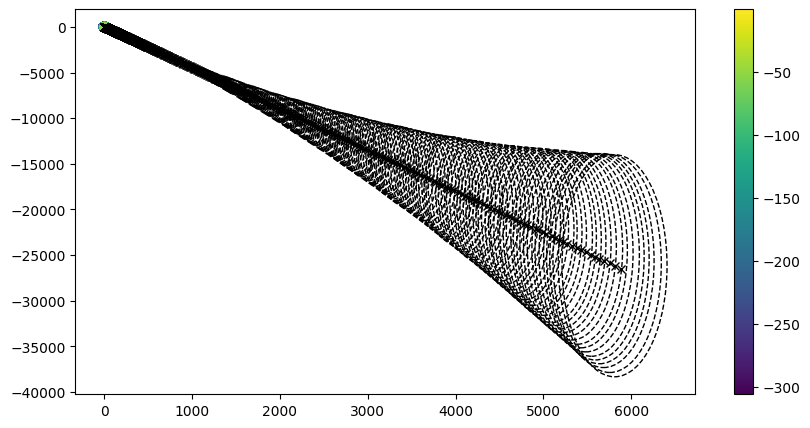

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

# sample points to show fitness landscape
x = jax.random.uniform(key, minval=-10, maxval=10, shape=(100000, 2))
f_x = fitness_func(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x)
fig.colorbar(points)

# plot cma-es trajectory
for mean, cov in zip(means, covs):
#     print("Mean: ", mean)
#     print("Covariance: ", cov)
#     print("Covariance: ", cov[0])
#     print("Covariance: ", cov[1])
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')